# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/) in two different ways: using [scikeras](https://www.adriangb.com/scikeras/refs/heads/master/index.html) (recommended) and using [keras.wrappers.scikit_learn](https://faroit.com/keras-docs/1.0.6/scikit-learn-api/) (old way, will be deprecated in a future release).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Using scikeras

In [50]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

from atom import ATOMClassifier, ATOMModel
from sklearn.preprocessing import FunctionTransformer
from skopt.space.space import Categorical

from scikeras.wrappers import KerasClassifier
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout

In [51]:
# Create the convolutional neural network
class ConvNN(KerasClassifier):
    """Convolutional neural network model."""

    @property
    def feature_encoder(self):
        """Convert the 2d input to the image's format (len(X), 28, 28, 1)."""
        return FunctionTransformer(
            func=lambda X: X.reshape(X.shape[0], 28, 28, 1),
        )

    @staticmethod
    def _keras_build_fn():
        """Create the model's architecture."""
        model = Sequential()
        model.add(
            Conv2D(
                filters=64,
                kernel_size=3,
                activation="relu",
                input_shape=(28, 28, 1),
            )
        )
        model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
        model.add(Flatten())
        model.add(Dense(units=10, activation="softmax"))
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        return model

In [52]:
# Convert the model to an ATOM model
model = ATOMModel(
    estimator=ConvNN(epochs=5, verbose=0),
    acronym="NN",
    fullname="Neural network",
)

In [53]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten data to follow sklearn's API (2d input)
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

data = (X_train, y_train), (X_test, y_test)

In [54]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ==================== >>
Shape: (7000, 785)
Memory: 5.50 MB
Scaled: False
Outlier values: 42042 (0.9%)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|   |     dataset |       train |        test |
| - | ----------- | ----------- | ----------- |
| 0 |   661 (1.0) |   572 (1.0) |    89 (1.1) |
| 1 |   825 (1.3) |   695 (1.3) |   130 (1.5) |
| 2 |   687 (1.1) |   587 (1.1) |   100 (1.2) |
| 3 |   650 (1.0) |   561 (1.0) |    89 (1.1) |
| 4 |   720 (1.1) |   629 (1.1) |    91 (1.1) |
| 5 |   656 (1.0) |   572 (1.0) |    84 (1.0) |
| 6 |   676 (1.0) |   552 (1.0) |   124 (1.5) |
| 7 |   768 (1.2) |   664 (1.2) |   104 (1.2) |
| 8 |   671 (1.0) |   576 (1.0) |    95 (1.1) |
| 9 |   686 (1.1) |   592 (1.1) |    94 (1.1) |



In [55]:
# Like any other model, we can define custom dimensions for the bayesian optimization
atom.run(
    models=model,
    metric="f1_weighted",
    n_calls=5,
    bo_params={
        "dimensions": [Categorical([32, 64, 128, 256], name="batch_size")],
        "max_time": 120,
    }
)


Training ========================= >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
| call             | batch_size | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ---------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |         64 |      0.9569 |           0.9569 | 24.866s |    24.868s |
| Initial point 2  |         64 |      0.9569 |           0.9569 |  0.001s |    24.933s |
| Initial point 3  |        256 |      0.9651 |           0.9651 | 21.802s |    46.801s |
| Initial point 4  |        256 |      0.9651 |           0.9651 |  0.001s |    46.867s |
| Initial point 5  |         64 |      0.9569 |           0.9651 |  0.001s |    46.933s |
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'batch_size': 256}
Best evaluation --> f1_weighted: 0.9651
Time elapsed: 47.078s
Fit ---------------------------------------------
Train evaluation --> f1_weighted:

## Using keras.wrappers.scikit_learn

In [56]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [57]:
# Create the convolutional neural network
def neural_network():
    """Create the model's architecture."""
    model = Sequential()
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [58]:
# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=5, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [59]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape data to fit model
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

data = (X_train, y_train), (X_test, y_test)

In [60]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
Memory: 1.02 MB
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|   |     dataset |       train |        test |
| - | ----------- | ----------- | ----------- |
| 0 |   659 (1.0) |   563 (1.1) |    96 (1.1) |
| 1 |   805 (1.3) |   698 (1.3) |   107 (1.3) |
| 2 |   732 (1.2) |   615 (1.2) |   117 (1.4) |
| 3 |   738 (1.2) |   642 (1.2) |    96 (1.1) |
| 4 |   694 (1.1) |   601 (1.2) |    93 (1.1) |
| 5 |   629 (1.0) |   545 (1.1) |    84 (1.0) |
| 6 |   713 (1.1) |   610 (1.2) |   103 (1.2) |
| 7 |   669 (1.1) |   585 (1.1) |    84 (1.0) |
| 8 |   632 (1.0) |   519 (1.0) |   113 (1.3) |
| 9 |   729 (1.2) |   622 (1.2) |   107 (1.3) |



In [61]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

,multidim feature,target
0,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",9
1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",2
3,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",7
4,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",4


In [62]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [63]:
# Like any other model, we can define custom dimensions for the bayesian optimization
atom.run(
    models=model,
    metric="f1_weighted",
    n_calls=5,
    bo_params={
        "dimensions": [Categorical([32, 64, 128, 256], name="batch_size")],
        "max_time": 120,
    }
)


Training ========================= >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
| call             | batch_size | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ---------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |         64 |      0.9627 |           0.9627 | 24.511s |    24.514s |
| Initial point 2  |        256 |      0.9452 |           0.9627 | 21.568s |    46.148s |
| Initial point 3  |        256 |      0.9452 |           0.9627 |  0.001s |    46.217s |
| Initial point 4  |        128 |      0.9626 |           0.9627 | 24.853s |     1m:11s |
| Initial point 5  |        128 |      0.9626 |           0.9627 |  0.001s |     1m:11s |
Bayesian Optimization ---------------------------
Best call --> Initial point 1
Best parameters --> {'batch_size': 64}
Best evaluation --> f1_weighted: 0.9627
Time elapsed: 1m:11s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 0

## Analyze the results

In [64]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[5.8496563e-14, 6.3283069e-17, 2.5753206e-16, ..., 3.5488775e-13,
        5.4223742e-13, 8.4204196e-14],
       [1.0000000e+00, 1.6548900e-15, 1.8278014e-10, ..., 6.3319707e-15,
        2.4255284e-11, 4.7824227e-11],
       [6.4183389e-19, 6.5628622e-13, 8.1421366e-13, ..., 3.6792547e-10,
        7.0455543e-14, 2.5547764e-09],
       ...,
       [5.2353426e-14, 1.2367661e-18, 2.6140497e-20, ..., 2.5399708e-21,
        6.5537471e-12, 1.9890034e-11],
       [1.1397011e-11, 6.8618496e-20, 1.8243494e-14, ..., 9.4443108e-12,
        4.7705595e-19, 1.9686952e-17],
       [2.1406321e-12, 2.0984077e-16, 2.9556364e-12, ..., 8.1968758e-11,
        9.9999893e-01, 8.9799136e-07]], dtype=float32)

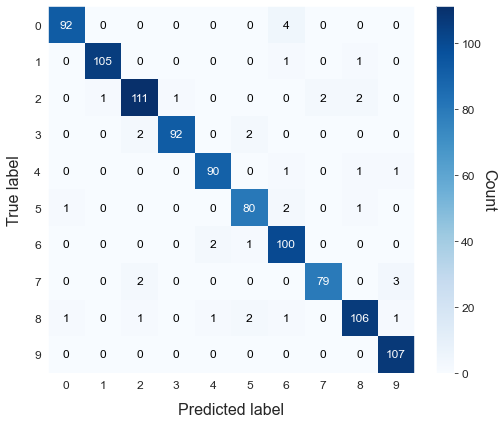

In [65]:
# Or make plots...
atom.nn.plot_confusion_matrix()